In [261]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces


from typing import Any, Literal
# from pandas import DataFrame



from typing import Any
# from numpy import dtype, floating
from pandas.core.frame import DataFrame
from pandas.core.series import Series



import torch
Tensor = torch.Tensor
import torch.nn as nn
from torch.optim import Adam, RMSprop


In [262]:
from IPython.display  import clear_output 

# %pip install backtrader

clear_output ()

In [263]:
%matplotlib inline

In [264]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [265]:
path_m5_xau : str = r"XAUUSDM5.csv"
path_m15_xau: str = r"XAUUSDM15.csv"
path_daiy_xau: str = r"XAUUSDDaily.csv"

path_m5_eur: str = r"EURUSDM5.csv"
path_m15_eur: str = r"EURUSDM15.csv"
path_daily_eur: str = r"EURUSDDaily.csv"


In [266]:
df = pd.read_csv(path_m5_xau , 
				   encoding = 'utf-16', 
				   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop=True, inplace = True)
df.drop('0', axis=1)


# variables

Open_ = df['Open']
close = df['Close']
# volume = data['Volume']
high = df['High']
time = df.index

Round = 4

rsi_len = 14

std_len = movAvgLen = 5

Vol_ma_1 = ma_1 = 10

Vol_ma_2 = ma_2 = 20


In [267]:
df.head()

,Open,High,Low,Close,Volume,0
Date,,,,,,
2025-04-16 01:00:00,3230.96,3231.07,3229.84,3230.80,199,0
2025-04-16 01:05:00,3230.80,3233.35,3230.68,3231.44,144,0
2025-04-16 01:10:00,3231.43,3232.56,3231.19,3232.16,139,0
2025-04-16 01:15:00,3232.15,3232.77,3231.74,3231.74,125,0
2025-04-16 01:20:00,3231.75,3232.47,3231.47,3232.38,111,0


In [268]:

def calculate_RSI(data: Series , time_window : int = 14) -> Series:
		delta: Series[type[float]] = data.diff() # type: ignore

		up, down = delta.copy(), delta.copy()
		up[up < 0] = 0 # type: ignore
		down[down > 0] = 0 # type: ignore

		roll_up: Series[float] = up.rolling(time_window).mean()
		roll_down: Series[float] = down.abs().rolling(time_window).mean()

		RS: Series[float] = roll_up / roll_down
		RSI: Series[float] = 100.0 - (100.0 / (1.0 + RS))

		return RSI.round(Round)



def macd(data, fast, slow):
	if isinstance(data, np.ndarray):
		ma1 =  np.convolve(data, np.ones(fast)/fast, mode='valid')
		ma2 =  np.convolve(data, np.ones(slow)/slow, mode='valid')
		return ma2 - ma1
	if isinstance(data, pd.Series):
		ma1 =  data.rolling(fast, min_periods=1).mean()
		ma2 =  data.rolling(slow, min_periods=1).mean()
		return ma2 - ma1



def clc_mean(series : Series , window: int) :
		rolling_mean = series.rolling(window=window).mean().round(Round)
		return  rolling_mean

def moving_avg_std(series : Series , window : int)  -> Series:
	"""Calculate the moving average and standard deviation of a pandas series, and then divide the two"""
	rolling_mean = series.rolling(window=window).mean().round(Round)
	rolling_std = series.rolling(window=window).std().round(Round)
	return rolling_mean - rolling_std



In [269]:
def creat_data(df: pd.DataFrame):
	df['MovAvg'] = df['Close'].rolling(movAvgLen).mean()

	df['diff']  =  (df['Close'] - df['MovAvg']).round(Round) 
	df['cadle-type']  = (df['Close'] - df['Open']).round(Round)
	df['hike'] = df['diff'] / df['cadle-type']
	df['change']  =  df['Open'] - df['MovAvg'] 
	df['macd'] = macd(df['Close'], movAvgLen, movAvgLen*2 )
	df['percent']  =  (close - df['Open']) / close  * 100

	df['rsi']  = calculate_RSI( df['Open'] , rsi_len ) / 100

	# df['std'] = std(df['Open'] , std_len)
	df['Pivot'] = (df['High'] + df['Low'] + df['Close']) / 3

	# Optional: First support and resistance
	df['R1'] = (2 * df['Pivot']) - df['Low']
	df['S1'] = (2 * df['Pivot']) - df['High']

	# df['mean'] = clc_mean(df['Open'] , std_len)

	# df['buy'] = np.where( (df['Open'] > clc_mean(df['Open'],movAvgLen).shift(1)) & (df['cadle-type'] >= .65), 1 ,0 )

	# df['sell'] = np.where( (df['Open'] < clc_mean(df['Open'],movAvgLen).shift(1)) & (abs(df['cadle-type']) >= .65)  , 1 ,0 )

	# df['hold'] = np.where(df['buy'] == df['sell'], 1, 0)

	# df['action'] = np.where(buyers == 1, 1,0)

	df = df.dropna(axis=0)

	return df

In [270]:
df = creat_data(df)

# df.tail()

data = df[
			['diff', 'Open', 'High', 'Low' , 'Close', 'Volume', 'MovAvg', 'macd'  ,'rsi', 'Pivot', "R1", "S1"]
					]
data.head()

,diff,Open,High,Low,Close,Volume,MovAvg,macd,rsi,Pivot,R1,S1
Date,,,,,,,,,,,,
2025-04-16 02:10:00,1.158,3238.81,3241.74,3238.81,3241.73,231,3240.572,-1.548,0.768652,3240.760000,3242.710000,3239.780000
2025-04-16 02:15:00,1.174,3241.77,3242.33,3240.10,3242.00,249,3240.826,-1.127,0.815049,3241.476667,3242.853333,3240.623333
2025-04-16 02:20:00,1.388,3241.97,3243.69,3241.10,3242.40,290,3241.012,-0.656,0.810365,3242.396667,3243.693333,3241.103333
2025-04-16 02:25:00,1.164,3242.41,3243.07,3242.09,3242.69,215,3241.526,-0.777,0.807186,3242.616667,3243.143333,3242.163333
2025-04-16 02:30:00,0.716,3242.68,3243.39,3242.31,3243.10,248,3242.384,-1.207,0.829813,3242.933333,3243.556667,3242.476667


In [271]:

from typing import Any
from numpy import floating


class MarketEnv(gym.Env):
	metadata = {"render_modes": ["human"], "render_fps": 4}

	def __init__(self, 
				 df: pd.DataFrame, 
				 win_size: int, 
				 sharpe_weight : float = .4,
				 shapre_compression : int = 5,
				 size : float = 0.01 ,
				 transaction_cost : float = 1e-2,
				 portfolio : float = 100,
				 risk_free_rate : float = 1e-2):
		super().__init__()
		self.df = df.reset_index(drop=True).astype(np.float32)
		self.win_size = win_size
		self.num_features = df.shape[1]
		self.current_step = self.win_size
		self.max_steps = len(df) - win_size - 1
		self.step_count : int = 0
		self.current_position : int = 0
		self.reward : float = 0.
		self.risk_free_rate: float = risk_free_rate
		self.trade_record: list[tuple[int, float]] = list()
		self.pnl : float = 0.
		self.sharpe_reward : float = 0.
		self.portfolio_Start = portfolio
		self.portfolio = portfolio
		self.size = size
		self.commission = transaction_cost
		self.sharpe_weight = sharpe_weight
		self.shapre_compression = shapre_compression
		self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
		self.observation_space = spaces.Box(
			low=-np.inf,
			high=np.inf,
			shape=(win_size, self.num_features),
			dtype=np.float32
		)
		self.state : np.ndarray

	def reset(self, *, seed=None, options=None):
		super().reset(seed=seed)
		self.current_step = self.win_size
		self.step_count = 0
		self.current_position = 0
		self.state = self._get_observation()
		self.trade_record.clear()
		self.pnl : float = 0.
		self.sharpe_reward : float = 0.
		self.portfolio = self.portfolio_Start
		return self.state, {}

	def _get_observation(self):
		window = self.df.iloc[self.current_step - self.win_size : self.current_step]
		return window.to_numpy()

	def _calc_pnl(self, prices: np.ndarray , action : int ) -> float:

		transaction_cost = (prices.sum()  *  self.size ) * self.commission

		return (prices.sum() * action *  self.size ) - transaction_cost

	def _calc_shapre(self):
		if len(self.trade_record) < 2:
			return 0.0  # جلوگیری از تقسیم بر صفر
		# print(self.trade_record[-self.shapre_compression:])
		excess_returns: np.ndarray = np.array(self.trade_record[-self.shapre_compression:]) - self.risk_free_rate
		mean_excess_return: floating[Any] = np.mean(excess_returns)
		std_excess_return: floating[Any] = np.std(excess_returns)
		
		if std_excess_return == 0:
			return 0.0
		
		sharpe: floating[Any] = mean_excess_return / std_excess_return
		return sharpe * np.sum(excess_returns)  


	def step(self, action : int, margin : float = 0.):

		# action += 1
		match action:
			case  0:
				real_action = 1  # Buy
			case 1:
				real_action = -1 # Sell
			case 2:
				real_action = 0  # Hold
		# State:
		# O: 0 | H: 1 | L: 2 | C: 3 | V: 4 | D: 5 |
		# print(f'state {self.state[:,5].sum()}')
		self.pnl = self._calc_pnl(self.state[:,0] , real_action )
		self.trade_record.append(( action ,self.pnl))
		
		self.sharpe_reward = self._calc_shapre()

		self.reward = ((1 - self.sharpe_weight) * self.pnl) + (self.sharpe_weight * self.sharpe_reward)
 
		self.current_step += 1
		self.step_count += 1
		self.current_position = action # type: ignore
		terminated: bool = False
		truncated: bool = self.step_count >= self.max_steps
		self.state = self._get_observation()
		self.portfolio += self.pnl

		info = {}
		return self.state, self.reward , terminated, truncated, info

	def render(self, mode="human"):
		print(f"Step: {self.step_count}, Reward: {self.reward:.4f}")


In [272]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
	def __init__(self, win_size , n_feature):
		super().__init__()

		self.norm_all = nn.LayerNorm(n_feature)
		
		self.i_know = nn.LSTM(input_size=n_feature, 
						hidden_size=n_feature,
						  num_layers= 128,
						  batch_first=True,
						  bidirectional= False
						  )
		

		# self.rnn = nn.RNN(input_size=n_feature,hidden_size=n_feature,num_layers=256,  batch_first=True, )
		
		self.i_see = nn.Sequential(
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=5, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU(),
			nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=3, padding='same'),
			nn.BatchNorm1d(win_size),
			nn.LeakyReLU()
			)

		self.i_decide = nn.Sequential(
			nn.Flatten(),
			nn.Dropout(.5),
			nn.Linear(win_size * n_feature, 128), # fc1
			nn.LeakyReLU(),
			nn.Linear(128, 128), # fc2
			nn.LeakyReLU(),
			nn.Linear(128, 3), # out
			# nn.Softmax()         
		)


	def forward(self, X: Tensor) -> Tensor:
		# print(f"before denorm\n{X}")
		x : Tensor = self.norm_all(X).unsqueeze(0)
		# print(f"after denorm\n{x}")
		iknow : Tensor
		iknow ,_ = self.i_know(x)

		isee : Tensor = self.i_see(iknow)
		# print(isee.shape)
		whathpend =  isee + iknow.tanh()

		out = self.i_decide(whathpend)

		return out




# تبدیل observation به بردار 1D برای ورودی شبکه
def preprocess_obs(obs : np.ndarray | Tensor) -> torch.Tensor:
	return torch.tensor(obs, dtype=torch.float32)


In [273]:
assert not data.isnull().any().any(), "NaN exists in dataframe!"

data.describe()

,diff,Open,High,Low,Close,Volume,MovAvg,macd,rsi,Pivot,R1,S1
count,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000,16196.000000
mean,0.008881,3322.106239,3323.693715,3320.438804,3322.108786,328.232712,3322.099905,-0.010970,0.511939,3322.080435,3323.722066,3320.467155
std,2.727019,55.571126,55.523052,55.602232,55.567196,86.788161,55.530395,2.331886,0.170295,55.553895,55.528926,55.609346
min,-44.396000,3125.430000,3129.880000,3120.780000,3125.400000,5.000000,3128.250000,-15.686000,0.015426,3125.480000,3130.180000,3120.700000
25%,-1.230500,3294.915000,3296.380000,3293.400000,3294.917500,276.000000,3295.074000,-1.205000,0.389633,3294.875833,3296.455833,3293.399167
50%,0.072000,3326.425000,3327.930000,3324.870000,3326.440000,331.000000,3326.540000,-0.066000,0.509717,3326.480000,3327.835000,3324.961667
75%,1.358000,3357.857500,3359.365000,3356.260000,3357.865000,385.000000,3357.641500,1.059000,0.633781,3357.800000,3359.331667,3356.350000
max,20.690000,3497.360000,3499.980000,3494.210000,3497.330000,1181.000000,3493.994000,25.022000,1.000000,3496.546667,3499.763333,3493.463333


In [274]:
from torch.distributions import Categorical

class SimpleRLAgent:
	def __init__(self, win_size, num_features ,action_dim):
		self.policy = PolicyNetwork (win_size=win_size, n_feature=num_features )
		self.policy.to(device)
		self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
		self.buffer = []  # Stores (log_prob, reward) pairs
	
	def select_action(self, state):
		state = torch.FloatTensor(state).to(device)#.unsqueeze(0)
		logits = self.policy(state)
		probs: Tensor = F.softmax(logits, dim=-1)  # Convert logits to probabilities
		
		m = Categorical(probs)
		action = m.sample().squeeze(0)
		# print(action)
		# Sample an action from the probability distribution
		# action = torch. multinomial(probs, 1).item()
		# print(action)
		log_prob: Tensor = m.log_prob(action) #F.log_softmax(logits, dim=-1)[0, action] # type: ignore
		
		return action, log_prob
	
	def update(self):
		if not self.buffer:
			return
		
		# Extract stored (log_prob, reward) pairs
		log_probs, rewards = zip(*self.buffer)
		log_probs = torch.stack(log_probs).to(device)
		rewards = torch.FloatTensor(rewards).to(device)
		
		# Normalize rewards (reduces variance)
		rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
		
		# Policy gradient loss: -log_prob * reward (maximize reward)
		loss = (-log_probs * rewards).mean()
		
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		
		self.buffer = []  # Clear buffer after update
		return loss.item()

In [275]:
torch.autograd.set_detect_anomaly(True)


In [276]:

window_size = 10

env = MarketEnv(df=data, 
				win_size=window_size,
			    risk_free_rate = 1e-1 ,
				sharpe_weight = .5 ,
				shapre_compression= 5,
				size= 0.01,
				transaction_cost = 2e-2,

			   )
obs, _ = env.reset()

# actor: PolicyNetwork   = PolicyNetwork (win_size=window_size, n_feature=env.num_features )

agent = SimpleRLAgent(win_size=window_size, 
					  num_features=env.num_features, 
					  action_dim=3)  # 3 discrete actions

# optim = optim.Adam(actor.parameters(), lr=1e-3, maximize=True)

gamma = 0.5
num_episodes = 10
max_steps = 1_00
reward_to_episodes = list()
done : bool = False

for episode in range(num_episodes):
	state ,_= env.reset()
	episode_reward = 0.
	
	# while not done:
	for step in range(max_steps):
		action, log_prob = agent.select_action(state)
		next_state, reward, terminated, truncated, _ = env.step(action) # type: ignore
		agent.buffer.append((log_prob, reward))
		
		state = next_state
		episode_reward += reward
		done: bool = terminated or truncated
		# env.render()
		# if done:
	agent.update()  # Update policy at the end of the episode
	print(f"Episode {episode+1} | Reward {episode_reward:.4f} | Gain {env.portfolio}")
	reward_to_episodes.append(episode_reward)
	# break

Episode 1 | Reward 130.2620 | Gain 101.26896667480469
Episode 2 | Reward 155.7591 | Gain 100.00019836425781
Episode 3 | Reward 136.4417 | Gain 97.78438568115234
Episode 4 | Reward 110.5170 | Gain 100.37301635742188
Episode 5 | Reward 147.4299 | Gain 100.39592742919922
Episode 6 | Reward 139.7851 | Gain 102.41270446777344
Episode 7 | Reward 99.4766 | Gain 100.3000259399414
Episode 8 | Reward 142.1303 | Gain 99.97492218017578
Episode 9 | Reward 124.6161 | Gain 99.78401184082031
Episode 10 | Reward 144.5879 | Gain 98.93206024169922


In [277]:
params = torch.tensor(0.0)

for name, param in agent.policy.named_parameters():
	params += param.size().numel()
	# print(name, param.size(),)

params

tensor(193015.)

In [278]:
print(f"""
portfolio   {env.portfolio}
max gain    {np.max(env.trade_record)  :.4f}
min gain    {np.min(env.trade_record)  :.4f}
mean gain   {np.mean(env.trade_record)  :.4f}
std gain   {np.std(env.trade_record)  :.4f}
median gain {np.median(env.trade_record)  :.4f}
""")


portfolio   98.93206024169922
max gain    2.0000
min gain    -0.4281
mean gain   0.5847
std gain   0.8465
median gain 0.0012



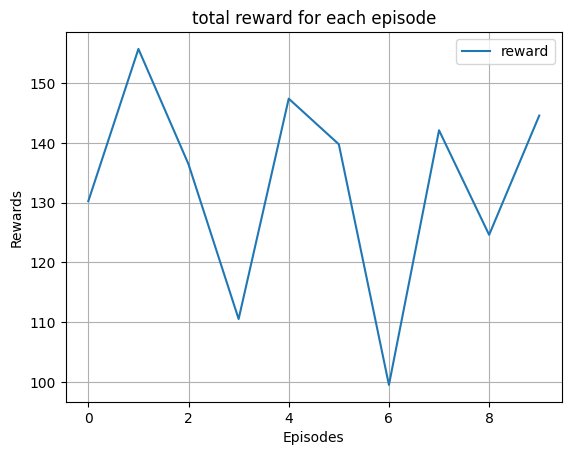

In [279]:
import seaborn as sns

sns.lineplot({"reward": reward_to_episodes})
plt.title("total reward for each episode")
plt.xlabel('Episodes')
plt.ylabel("Rewards")
plt.grid()
plt.show()

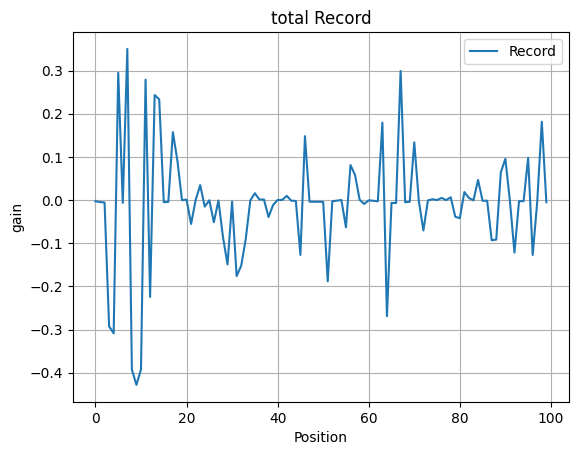

In [280]:
sns.lineplot({"Record": np.array(env.trade_record)[:,1] } )
# sns.scatterplot({'position': np.array(env.trade_record)[:,0] })
plt.title("total Record")
plt.xlabel('Position')
plt.ylabel("gain")
plt.grid()
plt.show()

In [281]:
n_features = env.num_features
n_rows = data.shape[0]
usable_rows = (n_rows // window_size) * window_size
data_trimmed = data.iloc[:usable_rows, :]

data_tensor = torch.tensor(data_trimmed.to_numpy(), dtype=torch.float).reshape(-1, window_size, n_features).to(device)
print(data_tensor.shape)

torch.Size([1619, 10, 12])


In [282]:
print(data_tensor.shape, data.shape)

torch.Size([1619, 10, 12]) (16196, 12)


In [283]:

labels = []
with torch.no_grad():
	agent.policy.eval()
	for state in data_tensor:
		probs  = F.softmax(agent.policy(state), dim=-1) # type: ignore
		action = torch.multinomial(probs, 1).item()
		labels.append(action)

tensor_labels = torch.tensor(labels)
print(tensor_labels)
# print(action)

tensor([0, 0, 0,  ..., 0, 0, 2])


In [284]:
print(f"""
uniques {torch.unique(tensor_labels, return_counts=True)}
labels.shape {tensor_labels.shape} 
data_tensor.shape {data_tensor.shape}
data.shape {data.shape} """)


uniques (tensor([0, 1, 2]), tensor([545, 478, 596]))
labels.shape torch.Size([1619]) 
data_tensor.shape torch.Size([1619, 10, 12])
data.shape (16196, 12) 


In [285]:

trade_df = data.copy()
labels_full = [2] * len(trade_df)  # مقدار پیش‌فرض برای همه ردیف‌ها

# تعداد ردیف‌هایی که برای مدل استفاده شدن
usable_rows = (len(df) // 5) * 5

for i, label in enumerate(tensor_labels):
	idx = i * 5
	if idx < len(labels_full):
		labels_full[idx] = label.item()   # type: ignore
		# باقی ۴ ردیف همان صفر باقی می‌مانند

data['signal'] = labels_full


data

# trade_df = data.copy()
# labels_full = [np.nan] * len(trade_df)
# for i, label in enumerate(labels):
#     for j in range(5):
#         labels_full[i*5 + j] = label.item()

# data['signal'] = labels_full
# data.head()

,diff,Open,High,Low,Close,Volume,MovAvg,macd,rsi,Pivot,R1,S1,signal
Date,,,,,,,,,,,,,
2025-04-16 02:10:00,1.158,3238.81,3241.74,3238.81,3241.73,231,3240.572,-1.548,0.768652,3240.760000,3242.710000,3239.780000,0
2025-04-16 02:15:00,1.174,3241.77,3242.33,3240.10,3242.00,249,3240.826,-1.127,0.815049,3241.476667,3242.853333,3240.623333,2
2025-04-16 02:20:00,1.388,3241.97,3243.69,3241.10,3242.40,290,3241.012,-0.656,0.810365,3242.396667,3243.693333,3241.103333,2
2025-04-16 02:25:00,1.164,3242.41,3243.07,3242.09,3242.69,215,3241.526,-0.777,0.807186,3242.616667,3243.143333,3242.163333,2
2025-04-16 02:30:00,0.716,3242.68,3243.39,3242.31,3243.10,248,3242.384,-1.207,0.829813,3242.933333,3243.556667,3242.476667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 21:00:00,-0.986,3309.46,3309.63,3308.07,3309.02,257,3310.006,0.872,0.383396,3308.906667,3309.743333,3308.183333,2
2025-07-09 21:05:00,0.398,3308.99,3311.21,3308.32,3310.37,317,3309.972,0.718,0.352809,3309.966667,3311.613333,3308.723333,2
2025-07-09 21:10:00,0.610,3310.37,3310.75,3309.41,3310.51,248,3309.900,0.643,0.449446,3310.223333,3311.036667,3309.696667,2


In [310]:
data['shifted'] = data['Close'].shift(5)#.mean()
data['true-diff'] = data['Close'] - data['shifted']

data['true-signal'] = 2  # default
data.loc[data['shifted'] <= data['Close'], 'true-signal'] = 0
data.loc[data['shifted'] >= data['Close'], 'true-signal'] = 1

data.dropna(inplace=True)
fliterd_data = data[['Close', 'shifted', 'true-diff','diff', 'signal', 'true-signal']]

fliterd_data = fliterd_data[(fliterd_data['true-signal'] == fliterd_data['signal']) & (fliterd_data['signal'] == 1)]

fliterd_data.describe()

,Close,shifted,true-diff,diff,signal,true-signal
count,219.000000,219.000000,219.000000,219.000000,219.0,219.0
mean,3298.047945,3302.745753,-4.697808,-1.757224,1.0,1.0
std,63.338984,63.056373,5.617819,3.843324,0.0,0.0
min,3128.750000,3137.590000,-55.150000,-44.396000,1.0,1.0
25%,3244.930000,3247.735000,-5.840000,-2.729000,1.0,1.0
50%,3307.760000,3311.400000,-3.060000,-1.174000,1.0,1.0
75%,3336.795000,3340.045000,-1.285000,0.014000,1.0,1.0
max,3488.400000,3490.100000,-0.010000,4.926000,1.0,1.0


In [304]:
accuracy = (data['true-signal'] == data['signal']).mean()

from sklearn.metrics import precision_score, recall_score, classification_report


report = classification_report(data['true-signal'], data['signal'])

print(f"""
accuracy {accuracy:.4%}
report
{report}
""")


accuracy 3.1879%
report
              precision    recall  f1-score   support

           0       0.55      0.04      0.07      8324
           1       0.46      0.03      0.05      7862
           2       0.00      0.00      0.00         0

    accuracy                           0.03     16186
   macro avg       0.34      0.02      0.04     16186
weighted avg       0.50      0.03      0.06     16186




In [288]:
np.unique(fliterd_data['signal'].to_numpy(), return_counts = True)

(array([0, 1, 2]), array([  544,   478, 15169]))

In [289]:
import backtrader as bt

# 1. Define a custom Pandas feed with signal line
class PandasSignalData(bt.feeds.PandasData):
	lines = ('signal',)  # add 'signal' column
	params = (('signal', -1),)  # tell backtrader where to find it (column index or name)


In [357]:
class TestStrategy(bt.Strategy):
	params = dict(
		tp_percent= .04 ,  # 5% take profit for buy
		sl_percent= .04 ,  # 2% stop loss for buy
		# tp_percent_short= 0.02 ,  # 5% take profit for sell
		# sl_percent_short= 0.02 ,  # 2% stop loss for sell
		max_hold= None ,    # maximum candle to hold on a position
		size = 0.01 
	)

	def __init__(self):
		self.signal = self.datas[0].signal
		self.entry_price = None
		self.bar_executed = None
		self.position_type = None  # 'long' یا 'short'
		self.size = 0.1

	def next(self):
		price_now = self.data.close[0]

		if not self.position:
			if self.signal[0] == 0:
				# if not self.position_type in ('short', None):
				self.close()
				self.entry_price = price_now
				self.buy(exectype= bt.Order.Market,
							size= self.size,
							tp = self.entry_price * (1 + self.p.tp_percent),
							sl = self.entry_price * (1 - self.p.sl_percent)
							)
				self.bar_executed = len(self)
				self.position_type = 'long'

			elif self.signal[0] == 1:
				# if not self.position_type in ('long', None):
				self.close()
				self.entry_price = price_now
				self.sell(exectype= bt.Order.Market,
							size= self.size,
							tp = self.entry_price * (1 - self.p.tp_percent),
							sl = self.entry_price * (1 + self.p.sl_percent)
							)
				self.entry_price = price_now
				self.bar_executed = len(self)
				self.position_type = 'short'

		else:
			pass
			if self.position_type == 'long':
				tp_price = self.entry_price * (1 + self.p.tp_percent)
				sl_price = self.entry_price * (1 - self.p.sl_percent)

				if price_now >= tp_price:
					self.close()
					print(f"Take Profit (long) hit at {price_now}")
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now <= sl_price:
					self.close()
					print(f"Stop Loss (long) hit at {price_now}")
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# پوزیشن شورت
			elif self.position_type == 'short':
				tp_price = self.entry_price * (1 - self.p.tp_percent)
				sl_price = self.entry_price * (1 + self.p.sl_percent)

				if price_now <= tp_price:
					self.close()
					print(f"Take Profit (short) hit at {price_now}")
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

				elif price_now >= sl_price:
					self.close()
					print(f"Stop Loss (short) hit at {price_now}")
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None

			# شرط زمانی خروج از هر نوع پوزیشن
			if not self.p.max_hold == None:
				if self.bar_executed and (len(self) - self.bar_executed) >= self.p.max_hold:
					self.close()
					# print(f"Time-based exit at {price_now}")
					self.position_type = None
					self.entry_price = None
					self.bar_executed = None




In [358]:
# 4. Feed into backtrader
trade_data = PandasSignalData(dataname=data) # type: ignore



cerebro = bt.Cerebro()
cerebro.adddata(trade_data)
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcash(10_000)
cerebro.broker
cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                     _name='sharpe', 
                     timeframe=bt.TimeFrame.Days,  # type: ignore
                    #  riskfreerate = 1e-1, 
                    #  compression = 5
                     )
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.broker.set_shortcash(True)

first_portfolio = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {first_portfolio}")
results = cerebro.run()
strategy = results[0]
last_portfolio = cerebro.broker.getvalue()
print(f"Final Portfolio Value:    {last_portfolio}" )
print(f"groose : { last_portfolio - first_portfolio}")



Starting Portfolio Value: 10000
Stop Loss (short) hit at 3398.92
Stop Loss (long) hit at 3263.65
Take Profit (long) hit at 3410.58
Take Profit (short) hit at 3271.71
Take Profit (short) hit at 3145.6
Take Profit (long) hit at 3270.89
Stop Loss (short) hit at 3413.8
Final Portfolio Value:    10012.502999999999
groose : 12.502999999998792


In [359]:
sharpe = strategy .analyzers.sharpe.get_analysis()
drawdown = strategy .analyzers.drawdown.get_analysis()

trades = strategy .analyzers.trades.get_analysis()
returns = strategy .analyzers.returns.get_analysis()

In [360]:
print(f"Sharpe Ratio: {sharpe.get('sharperatio', 'N/A')}")
print(f"Max Drawdown: {drawdown.max.drawdown:.2f}%")
print(f"Total Net Profit: {returns['rtot']*100:.2f}%")
# print(f"Profit Factor: {trades['pnl']['gross']['total'] / abs(trades['pnl']['gross']['loss']) if trades['pnl']['gross']['loss'] != 0 else 'inf'}")
print(f"Win Rate: {trades['won']['total'] / trades['total']['total'] * 100:.2f}%")


Sharpe Ratio: -0.043520308111733144
Max Drawdown: 0.34%
Total Net Profit: 0.12%
Win Rate: 57.14%


<IPython.core.display.Javascript object>

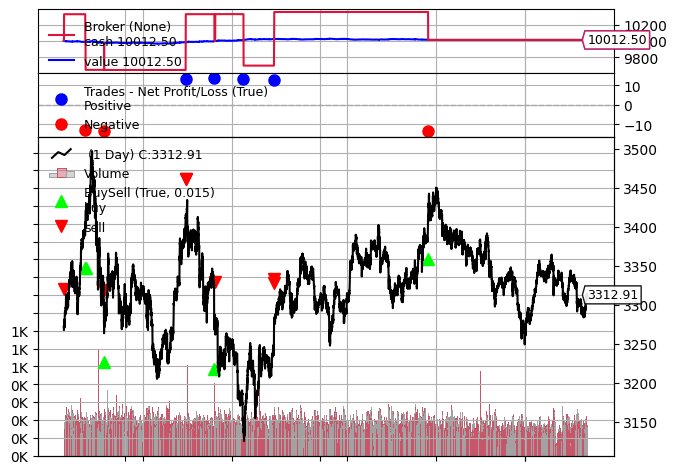

In [361]:
cerebro.plot(width = 50, height = 10)[0][0] # type: ignore

In [362]:
data['signal']

Date
2025-04-16 05:30:00    2
2025-04-16 05:35:00    2
2025-04-16 05:40:00    2
2025-04-16 05:45:00    2
2025-04-16 05:50:00    2
                      ..
2025-07-09 21:00:00    2
2025-07-09 21:05:00    2
2025-07-09 21:10:00    2
2025-07-09 21:15:00    2
2025-07-09 21:20:00    2
Name: signal, Length: 16156, dtype: int64

In [363]:
len(trade_data)

16156